# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


# Parameters

In [2]:
m=1
p = 0.01#0.4
q = 1#1.0#0.1#0.1#0.01#0.9#0.01#0.5 #Pure SF is q=0
run = 1

1

Choose your grid

In [3]:
global compactified=true
global loggrid=false
global bisection=false
global zeroformat=false
global twod=true

true

In [4]:
function compactify(r)
    x=r/(1+r)
    return x
end

compactify (generic function with 1 method)

In [5]:
using Quadmath, Printf

res=m;
N=2.0^m*200.0/2.0

if compactified==true
    Xf=1.0
else
    Xf=10.0
end

dx=Xf/N
if loggrid==false
    dt=0.5*round(dx,digits=10)
else
    dt=0.1*round(dx,digits=10)
end
Nt=N
Tf=Nt*dt;

In [6]:
print(N)

200.0

In [7]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA"

# Grid

In [8]:
using Printf
include("./YangMills.jl");

In [9]:
ori=0.0#Float128(0.0)#0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

if loggrid==true
    global originalX=initX
    xtilde=gridfunc(initX1)
    initX1=xtilde
    initX=collect(initX)
    initX[4:L-3]=xtilde
end;

step size is  0.005
the time step is 0.0025


# Initial data of m β Ψ and Ψ,x

In [10]:
using Dierckx


####

initm=zeros(L)
initbeta=zeros(L)
initpsi=zeros(L)
initpi=zeros(L)
initderxxchi=zeros(L)
initderpsi=zeros(L)
initxxchi=zeros(L)

#state array is m beta psi xxchi,u xxchi,rORx psi,r xxchi r
state_array=[initm initbeta initpsi initpi initderxxchi initderpsi initxxchi initX];
#attention:  in noncompactified code derxxchi is (xxchi),r. in compactified code derxxchi is (xxchi),x
#xxchi,u=pi

#PSI,R
A=0.075*p*(1−q)
r0=0.75
sigma=0.25

initderpsi[4:L-3] = init_derpsi(initX1,r0,sigma,A)

state_array[:,6] = initderpsi
state_array=ghost(state_array)

#XCHI
A=0.25*p*q
r0=0.3
sigma=0.1

initxxchi[4:L-3] = init_xxchi(initX1,r0,sigma,A)

state_array[:,7] = initxxchi

####
#PSI FROM PSI,R, CHI,R FROM CHI
xxchi_func = Spline1D(initX[4:L-3], state_array[4:L-3,7],  k=4);

state_array[4:L-3,5]=Der_arrayLOP(state_array,7,initX)[4:L-3]#derivative(xchi_func, initX1; nu=1)#Der_array(state_array,7,initX)[4:L-3]

derxxchi_func = Spline1D(initX[4:L-3], state_array[4:L-3,5],  k=4);
derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,6],  k=4);


funcs=[derxxchi_func derpsi_func xxchi_func];

In [11]:
y0=[0.0 0.0 0.0 0.0]
"""#fit
    ff(x, p) = p[1] .* x .+ p[2] .* x .^ 3 .+ p[3] .* x .^ 5
    p0 = [0.1, 0.001, 0.00001]
    fit = curve_fit(ff, state_array[4:16,8], state_array[4:16,7], p0);
    params=fit.param"""

state_array[4:L-3,1:4] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,funcs,state_array[:,:]);

#state_array = ghost(state_array);

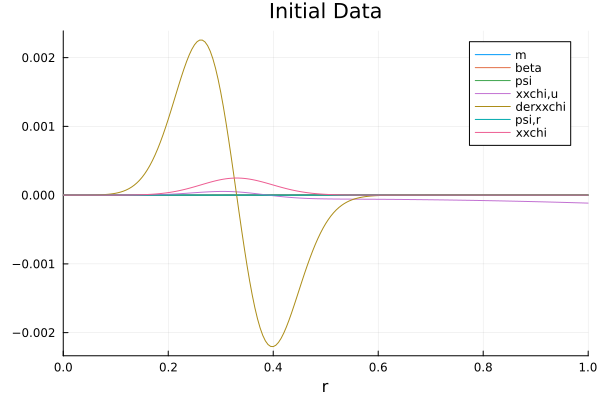

In [12]:
using Plots #showing initial data and the initial status of the horizon finder
plot((initX[4:L-3]), state_array[4:L-3,1:7], xaxis="r",title="Initial Data", labels=["m" "beta" "psi" "xxchi,u" "derxxchi" "psi,r" "xxchi"],xlim=[0,1])

In [13]:
function compactify(r)
    return r/(1+r)
end
function uncompactify(x)
    return x/(1-x)
end;

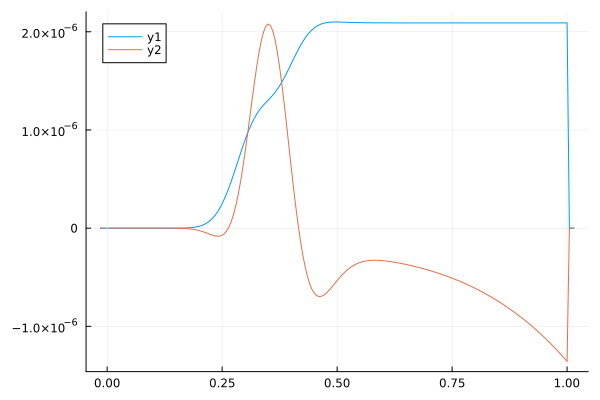

In [14]:
plot(initX, [state_array[:,1] masslossfunc(state_array)])#",xlim=([0,1]))

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [15]:
using CSV, Tables
#CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "deruxxchi", "derxchi", "derpsi", "xchi", "massloss"]

massloss = zeros(L)
massloss[4:L-3] = masslossfunc(state_array)[4:L-3]
print_muninn(files, 0, [state_array[:,1:7] massloss],res,"w", state_array[:,8])

In [16]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
global monitor_ratio = zeros(L);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

In [17]:
ginit=speed(initX,state_array[:,1],state_array[:,2])
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

2.02015100628772


In [18]:
using Base.Threads
Threads.nthreads()

4

In [19]:
if m==1
    global dt=2e-8
elseif m==2
    global dt=1e-6
else
    global dt=1e-6/2
end

2.0e-8

 ## Time evolution

fixed grid

In [20]:
finaltime=15.0
evol_stats, T_interp = timeevolution(state_array,finaltime,run);
#CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);



iteration 10 dt is 0.0050503775157193, t=0.050503775157193 speed is 0.4950125, dx/dt=0.990025


iteration 20 dt is 0.0050503775157193, t=0.10100755031438598 speed is 0.4950125, dx/dt=0.990025


iteration 30 dt is 0.0050503775157193, t=0.15151132547157894 speed is 0.4950125, dx/dt=0.990025


iteration 40 dt is 0.0050503775157193, t=0.2020151006287719 speed is 0.4950125, dx/dt=0.990025


iteration 50 dt is 0.0050503775157193, t=0.2525188757859649 speed is 0.4950125, dx/dt=0.990025


iteration 60 dt is 0.0050503775157193, t=0.30302265094315783 speed is 0.4950125, dx/dt=0.990025


iteration 70 dt is 0.005050377515719301, t=0.3535264261003508 speed is 0.49501249999999997, dx/dt=0.9900249999999999


iteration 80 dt is 0.005050377515719301, t=0.40403020125754374 speed is 0.49501249999999997, dx/dt=0.9900249999999999


iteration 90 dt is 0.005050377515719302, t=0.4545339764147367 speed is 0.4950124999999998, dx/dt=0.9900249999999996


iteration 100 dt is 0.005050377515719304, t=0.50503775157



iteration 710 dt is 0.005050378230782797, t=3.5857681345325663 speed is 0.495012429913097, dx/dt=0.990024859826194


iteration 720 dt is 0.005050377639514581, t=3.6362719133879446 speed is 0.49501248786621205, dx/dt=0.9900249757324241


iteration 730 dt is 0.0050503776395231835, t=3.6867756889697874 speed is 0.4950124878653689, dx/dt=0.9900249757307377


iteration 740 dt is 0.0050503791457496994, t=3.737279471941962 speed is 0.4950123402327034, dx/dt=0.9900246804654067


iteration 750 dt is 0.005050383384266275, t=3.7877832838883227 speed is 0.4950119247953297, dx/dt=0.9900238495906594


iteration 760 dt is 0.005050391765643745, t=3.8382871598220523 speed is 0.49501110329830805, dx/dt=0.990022206596616


iteration 770 dt is 0.005050405619889492, t=3.8887911487095432 speed is 0.4950097453864909, dx/dt=0.9900194907729817


iteration 780 dt is 0.00505042572853149, t=3.939295310291512 speed is 0.49500777446873256, dx/dt=0.990015548937465


iteration 790 dt is 0.005050451575618834, t=3.98

In [96]:
using LsqFit

tdata = [1, 2, 3]
ydata = [1, 4, 9]

ff(t, p) = p[1] * exp.(p[2] * t)
p0 = [0.5, 0.5]
fit = curve_fit(ff, tdata, ydata, p0);

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Int64}}([0.5832683311298664, 0.9148101953860868], [0.45601355006651345, -0.3653513403160016, 0.0731785282761912], [2.496301397439191 1.4560135500568188; 6.231520666775041 7.2692973195687145; 15.55575374834134 27.21953558655667], true, Int64[])

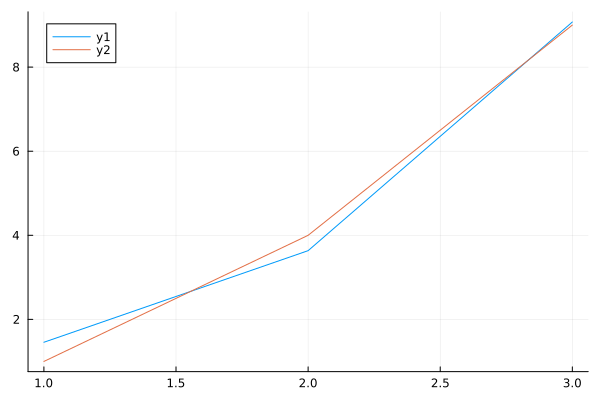

In [102]:
yfit = ff(tdata,fit.param)
plot(tdata, [yfit ydata])

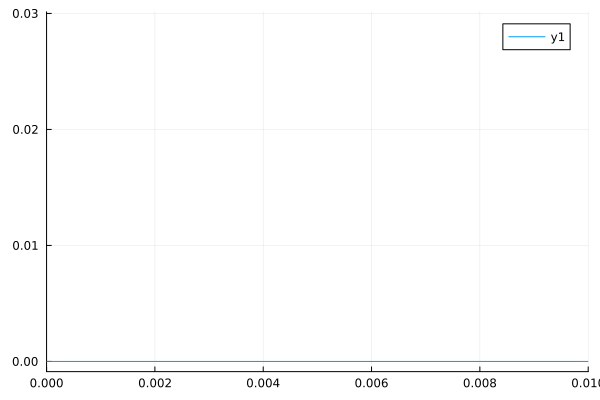

In [21]:
plot(initX,state_array[:,7],xlim=[0,0.01])

In [26]:
#yfit = ff(tdata,fit.param)
#plot(tdata, [yfit ydata])

state_array[4:8,7]
state_array[4:8,8]

5-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04

In [233]:
using LsqFit

xdata = state_array[4:8,8]
ydata = state_array[4:8,7]

ff(x, p) = p[1] .* x .+ p[2] .* x .^ 3 + p[3] .* x .^ 5 #xchi=p[1] .* x .+ p[2] .* x .^ 3 + p[3] .* x .^ 5
#derxchi = p[1] .+ 3 .* p[2] .* x .^ 2 + 5 .* p[3] .* x .^ 4
p0 = [0.1, 0.001, 0.00001]
fit = curve_fit(ff, xdata, ydata, p0);

In [234]:
print(fit.param)
ff([0 1], fit.param)

[6.176800334945096e-7, 0.001489995314443552, 0.0002529790800028037]

1×2 Matrix{Float64}:
 0.0  0.00174359

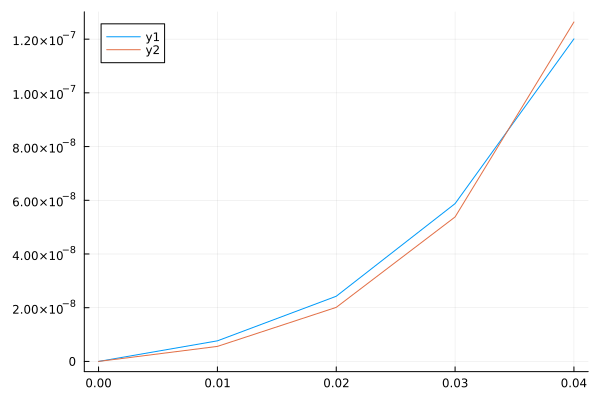

In [235]:
y=state_array[4:8,7]
yfit=transpose(ff(transpose(state_array[4:8,8]),fit.param))
x=state_array[4:8,8]

plot(x,[yfit y])